In [110]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

In [111]:
# Import data
data = pd.read_pickle('../data/connectivity_compliance_matrices.pkl')
data.rename(columns={'ρ':'rho'}, inplace=True)

# Calculate mean of E1, E2, E3
data['mean_E'] = data[['E1', 'E2', 'E3']].mean(axis=1)

# Extract relevant features
X = data[['connectivity_matrix', 'compliance_matrix', 'rho', 'mean_E']]
display(X.head())

connectivity_matrix  \
0  [[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                   compliance_matrix  rho    mean_E  
0  [[16.2442166588418, -4.3905896636785435, -4.39...  0.3  0.061528  
1  [[22.194443522542244, -7.18449266213412, -7.16...  0.3  0.045108  
2  [[21.448658158198008, -6.467827160497426, -6.4...  0.3  0.046636  
3  [[15.247634909853652, -3.931170890685161, -3.9...  0.3  0.065567  
4  [[23.16273271145176, -5.511611078765938, -5.66...  0.3  0.043226

In [ ]:
# Construct sample graph data consisting of edge index and node features (rho)
sample = X.iloc[0]
conn_mat = sample['connectivity_matrix']
C_mat = sample['compliance_matrix']
edge_index = np.array(np.nonzero(conn_mat)).T
rho = sample['rho']
display(sample['connectivity_matrix'])

rhos = np.array([rho] * conn_mat.shape[0])
num_neighbors = np.sum(conn_mat, axis=1)
node_features = np.column_stack((rhos, num_neighbors))
# print(f"Node features:\n{node_features}")

sample_data = Data(edge_index=torch.tensor(edge_index, dtype=torch.long), y=torch.tensor(C_mat, dtype=torch.float32))
print(f"Edge index:\n{sample_data.edge_index}")
print(f"Compliance matrix:\n{sample_data.y}")

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.]])

Edge index:
tensor([[ 0,  1],
        [ 0,  4],
        [ 1,  0],
        [ 1,  7],
        [ 2,  3],
        [ 2, 10],
        [ 3,  2],
        [ 3,  4],
        [ 4,  0],
        [ 4,  3],
        [ 4,  6],
        [ 4, 10],
        [ 6,  4],
        [ 6,  6],
        [ 7,  1],
        [ 7,  7],
        [10,  2],
        [10,  4]])
Compliance matrix:
tensor([[16.2442, -4.3906, -4.3921,  0.0000,  0.0000,  0.0000],
        [-4.3906, 16.2539, -4.3922,  0.0000,  0.0000,  0.0000],
        [-4.3921, -4.3922, 16.2602,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 38.9590,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 39.0762,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 39.0137]])


In [113]:
def construct_graph_data(row):
    # Extract matrices and features
    conn_mat = row['connectivity_matrix']
    C_mat = row['compliance_matrix']
    rho = row['rho']
    mean_E = row['mean_E']

    # Normalize compliance matrix
    print(f"cmatrix: \n{C_mat}")
    min_val = np.min(C_mat)
    max_val = np.max(C_mat)
    C_mat = (C_mat - min_val) / (max_val - min_val)
    # print(f"cmatrix normalized: \n{C_mat}")

    # Create edge index from connectivity matrix
    edge_index = np.array(np.nonzero(conn_mat)).T
    num_nodes = conn_mat.shape[0]

    # Create node features: rho and number of neighbors
    rhos = np.array([rho] * num_nodes)
    num_neighbors = np.sum(conn_mat, axis=1)

    # Create node features
    x = torch.tensor(np.column_stack((rhos, num_neighbors)), dtype=torch.float)
    graph_data = Data(x=x,
                      edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
                      y=torch.tensor(C_mat.flatten(), dtype=torch.float32),
                      mean_E=torch.tensor([mean_E], dtype=torch.float32))
    
    return graph_data



# Apply the function to the entire DataFrame to create a list of graph data objects
graph_data_list = X.apply(construct_graph_data, axis=1).tolist()
print(f"Constructed {len(graph_data_list)} graph data objects.")
print(f"Sample graph data object:\n{graph_data_list[0]}")
print(f"Sample normalized compliance matrix:\n{graph_data_list[0].y.reshape(6, 6)}")

cmatrix: 
[[16.24421666 -4.39058966 -4.39212236  0.          0.          0.        ]
 [-4.39058966 16.25385263 -4.39220148  0.          0.          0.        ]
 [-4.39212236 -4.39220148 16.26016853  0.          0.          0.        ]
 [ 0.          0.          0.         38.95901512  0.          0.        ]
 [ 0.          0.          0.          0.         39.07623774  0.        ]
 [ 0.          0.          0.          0.          0.         39.01373283]]
cmatrix: 
[[22.19444352 -7.18449266 -7.16736302  0.          0.          0.        ]
 [-7.18449266 22.17202179 -7.1458727   0.          0.          0.        ]
 [-7.16736302 -7.1458727  22.14088932  0.          0.          0.        ]
 [ 0.          0.          0.         37.8028957   0.          0.        ]
 [ 0.          0.          0.          0.         37.75579551  0.        ]
 [ 0.          0.          0.          0.          0.         37.74012152]]
cmatrix: 
[[21.44865816 -6.46782716 -6.4464256   0.          0.          0.   

In [114]:
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")
print('len(y) per graph =', len(train_data[0].y))
print(train_data[0])

# Determine node feature size and output (flattened compliance) size from a sample graph
num_node_features = int(train_data[0].x.shape[1])  # features per node
output_dim = int(train_data[0].y.shape[0])        # flattened compliance matrix length
num_nodes = int(np.sqrt(output_dim))
print(f"Node features per node: {num_node_features}")
print(f"Number of nodes per graph (sqrt of output dim): {num_nodes}")
print(f"Output dim (flattened compliance matrix): {output_dim}")

Training set size: 2099
Testing set size: 525
len(y) per graph = 36
Data(x=[11, 2], edge_index=[2, 21], y=[36], mean_E=[1])
Node features per node: 2
Number of nodes per graph (sqrt of output dim): 6
Output dim (flattened compliance matrix): 36


In [123]:
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

# keep embedding_size variable so earlier cells still work
embedding_size = 64

class GNN_v1(torch.nn.Module):
    """Graph-level regressor: N×GCNConv + configurable DNN."""
    def __init__(
        self,
        in_channels,
        embedding_size=128,          # width of each GCN layer unless conv_channels provided
        out_dim=36,
        dropout=0.0,
        mlp_layers=1,              # number of Linear->ReLU blocks before final output
        hidden_neurons=64,        # width of hidden layers in the DNN head
        num_convs=1,                # number of graph conv layers
        conv_channels=None          # optional list of widths per GCN layer; overrides embedding_size
    ):
        super(GNN_v1, self).__init__()
        torch.manual_seed(42)

        # ----- Graph conv stack (configurable depth/width) -----
        # If conv_channels is provided (e.g., [64, 128, 128]), use it; else repeat embedding_size.
        if conv_channels is not None:
            widths = list(map(int, conv_channels))
            assert len(widths) >= 1, "conv_channels must have at least one width"
        else:
            widths = [int(embedding_size)] * max(int(num_convs), 1)

        convs = []
        in_c = in_channels
        for w in widths:
            convs.append(GCNConv(in_c, w))
            in_c = w
        self.convs = torch.nn.ModuleList(convs)
        self.dropout = Dropout(dropout)

        # ----- DNN head: pooled embedding -> output -----
        last_embed = widths[-1]
        d_in = last_embed * 2  # concat of [gmp, gap]
        hdim = last_embed if hidden_neurons is None else int(hidden_neurons)

        layers = []
        if mlp_layers <= 0:
            layers.append(Linear(d_in, out_dim))
        else:
            layers += [Linear(d_in, hdim), torch.nn.ReLU(), Dropout(dropout)]
            for _ in range(mlp_layers - 1):
                layers += [Linear(hdim, hdim), torch.nn.ReLU(), Dropout(dropout)]
            layers.append(Linear(hdim, out_dim))

        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, data):
        # expects a batched torch_geometric.data.Data with attributes: x, edge_index, batch
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GCN stack with ReLU after each conv
        h = x
        for conv in self.convs:
            h = conv(h, edge_index)
            h = F.relu(h)

        # global pooling: concat max and mean
        hg = torch.cat([gmp(h, batch), gap(h, batch)], dim=1)
        hg = self.dropout(hg)

        out = self.mlp(hg)  # [batch_size, out_dim]
        return out


In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Loss and optimizer: total sum of squared error (per batch) BRENNAN TRYING TO DO MEAN SQUARED ERROR)
loss_fn = torch.nn.MSELoss(reduction='mean')  # sums (pred - target)^2 over all elements
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data loaders
NUM_GRAPHS_PER_BATCH = 32
train_loader = DataLoader(train_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

def train_epoch(loader):
    model.train()
    running_sum = 0.0  # accumulate total sum of squared errors over the epoch
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch)                         # [B, out_dim]
        print(f"pred shape: {pred.shape}")
        print(f"pred: {pred}")
        target = batch.y.view_as(pred).to(device)   # [B, out_dim]
        print(f"target shape: {target.shape}")
        print(f"target: {target}")

        loss = loss_fn(pred, target)                # sum of squared errors over all compliance terms
        loss.backward()
        optimizer.step()

        running_sum += float(loss.item())
    return running_sum  # total SE for the epoch (not averaged)

print("Starting training...")
losses = []
EPOCHS = 50
for epoch in range(EPOCHS):
    train_loss = train_epoch(train_loader)
    losses.append(train_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Train SumSqErr {train_loss:.6f}")

# from torch_geometric.data import DataLoader
# import warnings
# warnings.filterwarnings("ignore")

# # Loss and optimizer
# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# # Use GPU for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Wrap data in data loaders (use the previously created train_data/test_data lists)
# NUM_GRAPHS_PER_BATCH = 32
# train_loader = DataLoader(train_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

# def train_epoch(loader):
#     model.train()
#     running_loss = 0.0
#     for batch in loader:
#         # Move batch to device
#         batch = batch.to(device)
#         optimizer.zero_grad()
#         # Forward pass (model expects a single 'data' object)
#         pred = model(batch)
#         # Ensure target is on the same device and has matching shape
#         target = batch.y.view_as(pred).to(device)
#         loss = loss_fn(pred, target)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     return running_loss / len(loader)

# print("Starting training...")
# losses = []
# EPOCHS = 500
# for epoch in range(EPOCHS):
#     train_loss = train_epoch(train_loader)
#     losses.append(train_loss)
#     if epoch % 5 == 0:
#         print(f"Epoch {epoch} | Train Loss {train_loss:.6f}")

Starting training...
pred shape: torch.Size([32, 36])
pred: tensor([[0.4010, 0.0016, 0.0013,  ..., 0.0856, 0.0857, 0.9933],
        [0.4010, 0.0016, 0.0013,  ..., 0.0856, 0.0857, 0.9933],
        [0.4010, 0.0016, 0.0013,  ..., 0.0856, 0.0857, 0.9933],
        ...,
        [0.4010, 0.0016, 0.0013,  ..., 0.0856, 0.0857, 0.9933],
        [0.4010, 0.0016, 0.0013,  ..., 0.0856, 0.0857, 0.9933],
        [0.4010, 0.0016, 0.0013,  ..., 0.0856, 0.0857, 0.9933]],
       grad_fn=<AddmmBackward0>)
target shape: torch.Size([32, 36])
target: tensor([[8.8268e-01, 1.5845e-03, 0.0000e+00,  ..., 1.9144e-01, 1.9144e-01,
         1.0000e+00],
        [3.2845e-01, 3.5947e-04, 1.0640e-04,  ..., 5.2974e-02, 5.2974e-02,
         9.9852e-01],
        [7.7727e-01, 3.5259e-04, 0.0000e+00,  ..., 2.0558e-01, 2.0558e-01,
         1.0000e+00],
        ...,
        [5.4562e-01, 0.0000e+00, 3.2080e-05,  ..., 1.4688e-01, 1.4688e-01,
         9.9872e-01],
        [3.8351e-01, 0.0000e+00, 1.8560e-04,  ..., 7.2653e-02, 7.

KeyboardInterrupt: 

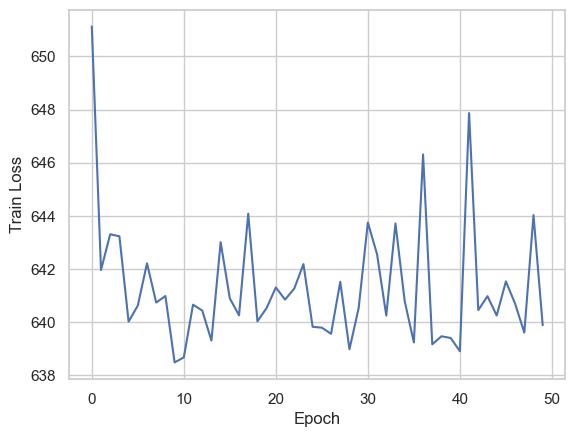

In [ ]:
# Visualize training loss
import seaborn as sns
import matplotlib.pyplot as plt
# losses may be tensors or floats depending on how they were collected; handle both
losses_float = [float(l.cpu().detach().numpy()) if hasattr(l, 'cpu') else float(l) for l in losses]
loss_indices = list(range(len(losses_float)))
sns.set(style="whitegrid")
ax = sns.lineplot(x=loss_indices, y=losses_float)
ax.set(xlabel="Epoch", ylabel="Train Loss")
plt.show()

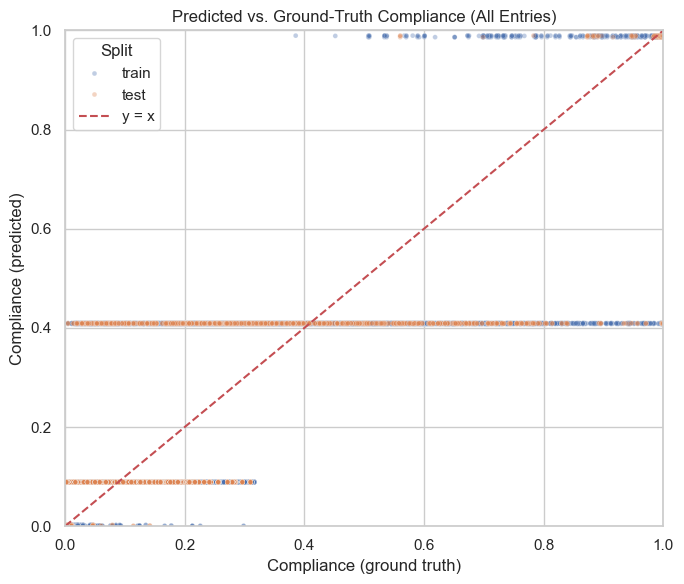

In [ ]:
# # Plot predicted E (model output reduced to a scalar) vs. the stored mean_E for each graph
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import torch
# # Grab one batch from the test loader
# test_batch = next(iter(test_loader))
# with torch.no_grad():
#     test_batch = test_batch.to(device)
#     pred = model(test_batch)  # shape: [batch_size, out_dim]
# # Reduce the model output to a single predicted E per graph (use mean over output vector)
# pred_E = pred.mean(dim=1).cpu().numpy()
# # Extract stored mean_E that we added to each Data object during construction
# mean_E_vals = test_batch.mean_E.view(-1).cpu().numpy()
# # Build DataFrame and show a quick preview
# df = pd.DataFrame({'mean_E': mean_E_vals, 'pred_E': pred_E})
# display(df.head())
# # Scatter plot: predicted vs ground-truth mean_E
# sns.set(style="whitegrid")
# ax = sns.scatterplot(data=df, x='mean_E', y='pred_E')
# # Add y=x reference line
# xmin, xmax = df['mean_E'].min(), df['mean_E'].max()
# ax.plot([xmin, xmax], [xmin, xmax], 'r--', label='y=x')
# ax.set(xlabel='mean_E (ground truth)', ylabel='predicted E (mean of model output)')
# ax.legend()
# plt.show()

# ---------- Evaluation utilities ----------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_split(loader, split_name, model, device):
    """Run inference over a DataLoader and return a long-form DataFrame
    with flattened ground-truth and predictions for all compliance entries."""
    model.eval()
    ys, preds, comps = [], [], []
    with torch.no_grad():  # disable autograd for evaluation
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)                     # [B, out_dim]
            target = batch.y.view_as(pred)          # [B, out_dim]

            p = pred.detach().cpu().numpy().ravel()  # flatten all entries
            t = target.detach().cpu().numpy().ravel()

            ys.append(t)
            preds.append(p)

    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)
    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "split": split_name
    })
    return df

# Evaluate on both splits
train_df = evaluate_split(train_loader, "train", model, device)
test_df  = evaluate_split(test_loader,  "test",  model, device)
comb_df  = pd.concat([train_df, test_df], ignore_index=True)

# ---------- Plot: all compliance entries train+test ----------
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(
    data=comb_df,
    x="y_true",
    y="y_pred",
    hue="split",
    alpha=0.35,
    s=12,
    ax=ax
)

# Identity line y = x over combined range
xy_min = float(min(comb_df["y_true"].min(), comb_df["y_pred"].min()))
xy_max = float(max(comb_df["y_true"].max(), comb_df["y_pred"].max()))
# Use axline to draw the identity line regardless of axis range
ax.axline((0, 0), slope=1.0, color="r", linestyle="--", linewidth=1.5, label="y = x")

# Tight axes spanning observed range
ax.set_xlim(xy_min, xy_max)
ax.set_ylim(xy_min, xy_max)

ax.set_xlabel("Compliance (ground truth)")
ax.set_ylabel("Compliance (predicted)")
ax.legend(title="Split")
ax.set_title("Predicted vs. Ground-Truth Compliance (All Entries)")

plt.tight_layout()
plt.show()
